<a href="https://colab.research.google.com/github/luchosic/SOA/blob/main/HPC/Cuaderno_2_grupo3_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Introducción

En este ejercicio vamos a demostrar cómo varia el tiempo de ejecución de un programa que multiplica matrices, utilizando CPU vs GPU. Este es un típico problema donde el uso de la GPU ayuda a disminuir el tiempo de procesamiento cuando la complejidad del algoritmo aumenta.</br></br>

La multiplicación de matrices se realiza de la siguiente forma:

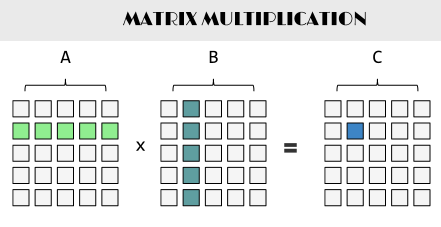


# 2 Armado del ambiente



In [12]:
#@title ## 2.1 Parámetros de ejecución
#@markdown ### Especifique el inicio del rango de valores numéricos que tendrá la matriz
inicio_rango =   1#@param {type: "number"}
#@markdown ### Especifique el fin del rango de valores numéricos que tendrá la matriz
fin_rango =   50#@param {type: "number"}

#@markdown ### Especifique el tamaño de la matriz
tamano_matriz =   300#@param {type: "number"}

# 3 Desarrollo CPU

In [13]:
%matplotlib inline
from datetime import datetime

tiempo_total_cpu = datetime.now()

import matplotlib.pyplot as plt
import numpy
import random

#inicializo las matrices cuadradas con valores random dentro del rango ingresado por el usuario
matriz_a = (fin_rango - inicio_rango) * numpy.random.random((tamano_matriz, tamano_matriz)) + inicio_rango
matriz_b = (fin_rango - inicio_rango) * numpy.random.random((tamano_matriz, tamano_matriz)) + inicio_rango
matriz_resultado = (fin_rango - inicio_rango) * numpy.random.random((tamano_matriz, tamano_matriz)) + inicio_rango


# Itero por filas de X
for i in range(len(matriz_a)):
   # Itero por columnas de Y
   for j in range(len(matriz_b[0])):
       # itero por filas de Y
       for k in range(len(matriz_b)):
           matriz_resultado[i][j] += matriz_a[i][k] * matriz_b[k][j]

if tamano_matriz <= 10:
  print( "\n\nMatriz Resultado:" )
  for r in matriz_resultado:
    print(r)
else:
  print( "\n\nListo! Ya calculamos tu matriz resultado. Como es muy grande, no la mostramos por pantalla :)" )

tiempo_total_cpu = datetime.now() - tiempo_total_cpu  



Listo! Ya calculamos tu matriz resultado. Como es muy grande, no la mostramos por pantalla :)


# 4 Desarrollo GPU

# 4.1 Instala en el cuaderno el módulo CUDA de Python.

In [14]:
!pip install pycuda

# 4.2 Procesamiento con GPU

In [18]:
%matplotlib inline
from datetime import datetime
tiempo_total_gpu = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

#Inicializo las matrices con valores random dentro del rango ingresado por el usuario, del tamaño establecido tambien por parámetro
matriz_a = (fin_rango - inicio_rango) * numpy.random.random((tamano_matriz, tamano_matriz)) + inicio_rango
matriz_a = matriz_a.astype(numpy.float32)
matriz_b = (fin_rango - inicio_rango) * numpy.random.random((tamano_matriz, tamano_matriz)) + inicio_rango
matriz_b = matriz_b.astype(numpy.float32)
matriz_resultado = (fin_rango - inicio_rango) * numpy.random.random((tamano_matriz, tamano_matriz)) + inicio_rango
matriz_resultado = matriz_resultado.astype(numpy.float32)

#Reservo espacio en memoria GPU
matriz_a_gpu = cuda.mem_alloc(matriz_a.nbytes)
matriz_b_gpu = cuda.mem_alloc(matriz_b.nbytes)
matriz_resultado_gpu = cuda.mem_alloc(matriz_resultado.nbytes)

#Copio las matrices a GPU
cuda.memcpy_htod(matriz_a_gpu, matriz_a)
cuda.memcpy_htod(matriz_b_gpu, matriz_b)
cuda.memcpy_htod(matriz_resultado_gpu, matriz_resultado)



# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void matrixMultiplicationKernel(float* A, float* B, float* C, int N) {
    int ROW = threadIdx.x + blockIdx.x*blockDim.x;
    int COL = threadIdx.y + blockIdx.y*blockDim.y;
    float tmpSum = 0;
    if (ROW < N && COL < N) {
        // each thread computes one element of the block sub-matrix
        for (int i = 0; i < N; ++i) {
            tmpSum += A[ROW * N + i] * B[i * N + COL];
        }
        C[ROW * N + COL] = tmpSum;
    }
}
""") 

# CPU - Genero la función kernel.
kernel = module.get_function("matrixMultiplicationKernel")

dim_hilo_x = 16
dim_bloque_x = numpy.int( (tamano_matriz+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (tamano_matriz+dim_hilo_y-1) / dim_hilo_y )

#Ejecuto la funcion de kernel
kernel(matriz_a_gpu, matriz_b_gpu, matriz_resultado_gpu, numpy.int32(tamano_matriz), block=(dim_hilo_x, dim_hilo_y, 1), grid=(dim_bloque_x, dim_bloque_y,1))

 # GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh(matriz_resultado, matriz_resultado_gpu)

if tamano_matriz <= 10:
  print( "\n\nMatriz Resultado:" )
  for r in matriz_resultado:
    print(r)
else:
  print( "\n\nListo! Ya calculamos tu matriz resultado. Como es muy grande, no la mostramos por pantalla :)" )

tiempo_total_gpu = datetime.now() - tiempo_total_gpu





Listo! Ya calculamos tu matriz resultado. Como es muy grande, no la mostramos por pantalla :)


# 5 Métricas

In [17]:
from tabulate import tabulate
data = [['Tiempo total de procesamiento', tiempo_total_cpu, tiempo_total_gpu]]
print (tabulate(data, headers=["Métrica", "CPU", "GPU"]))

print( "\n\nDatos de corrida con GPU:" )
print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )




Métrica                        CPU             GPU
-----------------------------  --------------  --------------
Tiempo total de procesamiento  0:00:39.735110  0:00:01.303929


Datos de corrida con GPU:
Thread: [ 16 , 19  ], Bloque : [ 19 , 16 ]
Total de Thread: [ 304 , 304  ]  =  92416


---
# 6 Conclusiones

Luego de numerosas pruebas, pudimos comprobar que el uso de GPU mejora notablemente el tiempo de ejecución del algoritmo. <br><br>
Sin embargo, se debe tener en consideración que si el tamaño de la matriz a procesar es relativamente pequeño (por ejemplo, de 4x4), no es conveniente el uso de GPU, ya que este toma más tiempo. Esto se debe a que no siempre se justifica el acceso a GPU, sobre todo para procesamientos pequeños, ya que hay muchas capas intermedias entre la aplicación que se está ejecutando y el GPU.<br>
De modo contrario, cuanto mayor sea el tamaño de la matriz, más diferencia habrá entre el tiempo de procesamiento por CPU y GPU, escalando este exponencialmente.

---
# 7 Bibliografía

1.   Matrix-Matrix Multiplication on the GPU with Nvidia CUDA: [Página Web](https://www.quantstart.com/articles/Matrix-Matrix-Multiplication-on-the-GPU-with-Nvidia-CUDA/)
2.  Python program to multiply two matrices: [Página Web](https://www.geeksforgeeks.org/python-program-multiply-two-matrices/)

